In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
from pandas.core.common import flatten
from glob import glob
import seaborn as sns
import pandas as pd
import imp 
import pickle
from random import randrange

from utils.mg_utils import iou, calculate_roi_measures

/media/data/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/data/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/data/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/media/data/anaconda3/envs/tf114/lib/python3.7/site-

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

In [3]:
cf = imp.load_source('cf', '/media/data/home/s370876/evaluation/wue_lab_eval_config.py')
path = cf.out_dir

## IoU (6 samples)

In [4]:
#set seed for reproducibility
np.random.seed(0)

In [5]:
def batch_six(cf):

    """Assembles a batch of the first image for each specified patient.
    A tuple holding the batched image of shape (b, 1, 128, 128) and the batched
    segmentations of shape (b, 4, 128, 128).
    """
    img, seg, ids, samples, avg_masks, avg_experts = [], [], [], [], [], []
    img_ixs = glob(os.path.join(cf.out_dir, 'images', '*'))

    for i in range(len(img_ixs)):
        # get the first image for the patient
        img_path = img_ixs[i]
        pth_split = img_path.rsplit('/', 1)[-1][:-4]
        ids.append(pth_split)

        image = np.load(img_path)
        #image = image[np.newaxis, np.newaxis, ...]
        img.append(image)

        # get the corresponding ground truth label
        gt_base_path = img_path.replace('images', 'gt')
        # Für alle 4 Expertenmasken zu bestimmtem Bild:
        labels = []
        for l in range(cf.num_graders):
            gt_path = gt_base_path.replace('.npy', '_l{}.npy'.format(l))
            label = np.load(gt_path)
            labels.append(label)
        labels = np.concatenate(labels, axis=1)
        avg_expert = np.sum(labels, axis = 1)
        avg_experts.append(avg_expert)
        seg.append(labels)
        
        # Samples
        sample_base_path = img_path.replace('images/', '')
        sample_list = []
        for i in range(cf.num_samples):
            new_path = sample_base_path.replace('.npy', '_sample{}.npy'.format(i))
            sample = np.load(new_path)
            sample_list.append(sample)
        array = np.concatenate(sample_list, axis=1)
        avg_mask = np.sum(array, axis = 1)
        avg_masks.append(avg_mask)
        samples.append(array)
    
    # Concat and rearrange np arrays for BHWC format
    img_batch = np.concatenate(img, axis=0)
    img_batch = np.transpose(img_batch, (0, 2, 3, 1))
    seg_batch = np.concatenate(seg, axis=0)
    seg_batch = np.transpose(seg_batch, (0, 2, 3, 1))
    sample_batch = np.concatenate(samples, axis=0)
    sample_batch = np.transpose(sample_batch, (0, 2, 3, 1))
    avg_expert_batch = np.concatenate(avg_experts, axis=0)
    avg_mask_batch = np.concatenate(avg_masks, axis=0)
   

    batch = {'data': np.array(img_batch).astype('float32'), 'seg': np.array(seg_batch).astype('uint8'),
             'sample': np.array(sample_batch).astype('uint8'), 'avg_masks': np.array(avg_mask_batch).astype('uint8'),
             'avg_experts': np.array(avg_expert_batch).astype('uint8'), 'id': ids}

    return batch

In [6]:
batch = batch_six(cf)

In [7]:
def mean_iou(mask_list1, mask_list2):
    
    ious = []
    length = len(mask_list1)
    
    for i in range(length):
        single_iou = iou(mask_list1[i], mask_list2[i])
        ious.append(single_iou)

    mean_iou = sum(ious)/length
    
    return mean_iou, ious

In [8]:
ds_iou = mean_iou(batch['avg_masks'], batch['avg_experts']); ds_iou[0]

0.44501395648217734

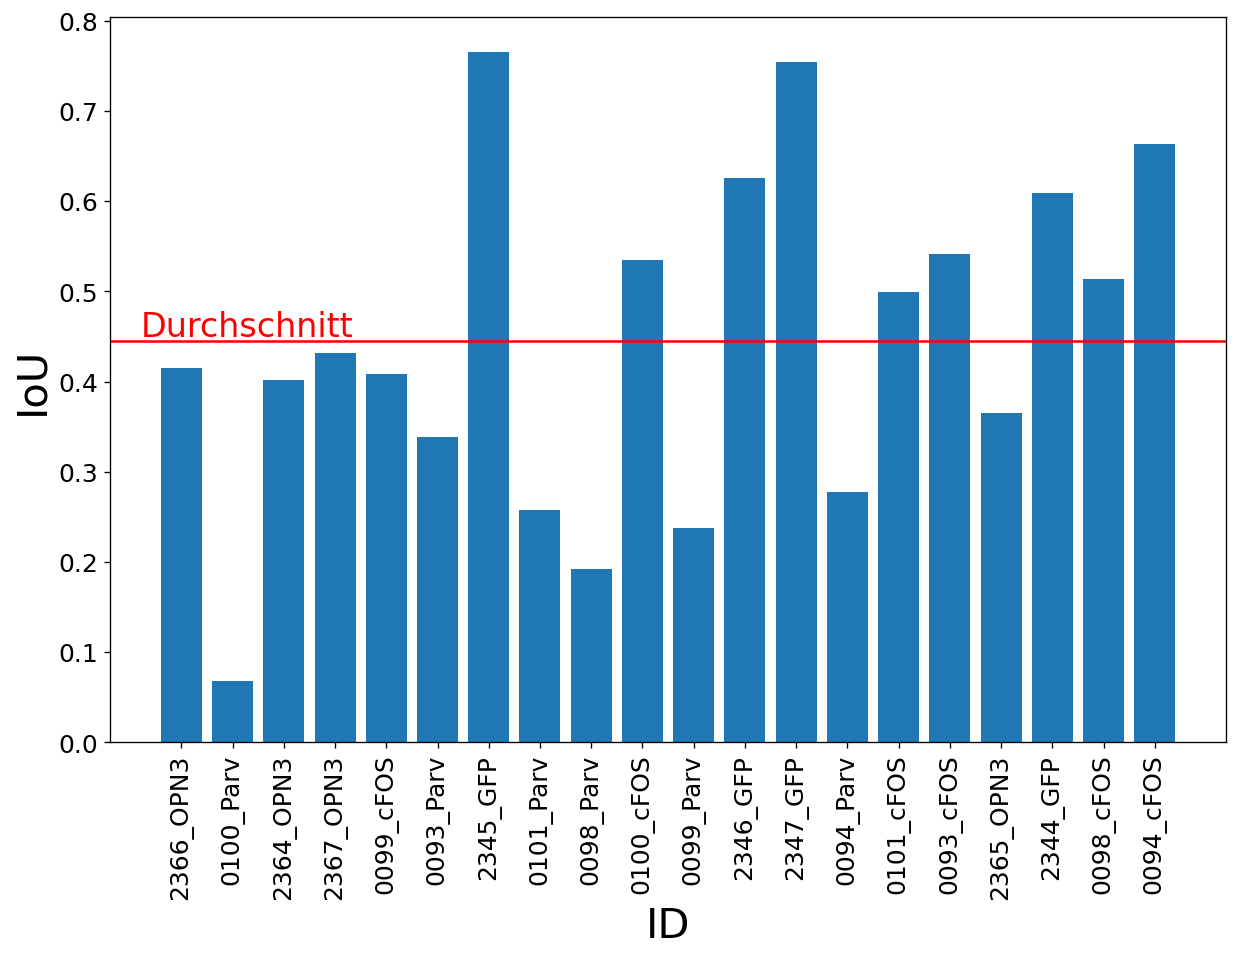

In [25]:
fig=plt.figure(figsize=(12,8), dpi=120)
plt.bar(x=batch['id'],height=ds_iou[1])
plt.ylabel('IoU').set_fontsize(25)
plt.xlabel('ID').set_fontsize(25)
plt.xticks(fontsize = 15, rotation=90)
plt.yticks(fontsize = 15)
plt.text(-0.8,0.45, 'Durchschnitt', color = 'r', fontsize=20)
plt.axhline(ds_iou[0], color='r')
plt.savefig(os.path.join(cf.out_dir, 'plots/ds_mean_ious.png'), bbox_inches='tight')

In [10]:
def get_sublist(ds_string, batch):
    indices = [s for s, n in enumerate(batch['id']) if ds_string in n]
    
    id_list = [batch['id'][i] for i in indices]
    sample_avg_list = [batch['avg_masks'][i] for i in indices]
    exp_avg_list = [batch['avg_experts'][i] for i in indices]
    
    batch = {'avg_masks': np.array(sample_avg_list), 'avg_experts': np.array(exp_avg_list), 'id': id_list}
    
    return batch

In [11]:
parv_list = get_sublist('Parv', batch)
gfp_list = get_sublist('GFP', batch)
opn_list = get_sublist('OPN3', batch)
cfos_list = get_sublist('cFOS', batch)

In [12]:
parv_iou = mean_iou(parv_list['avg_masks'], parv_list['avg_experts']); parv_iou[0]

0.2285883902095065

In [13]:
gfp_iou = mean_iou(gfp_list['avg_masks'], gfp_list['avg_experts']); gfp_iou[0]

0.6886816516299668

In [14]:
opn_iou = mean_iou(opn_list['avg_masks'], opn_list['avg_experts']); opn_iou[0]

0.40304858792494436

In [15]:
cfos_iou = mean_iou(cfos_list['avg_masks'], cfos_list['avg_experts']); cfos_iou[0]

0.5269713050278106

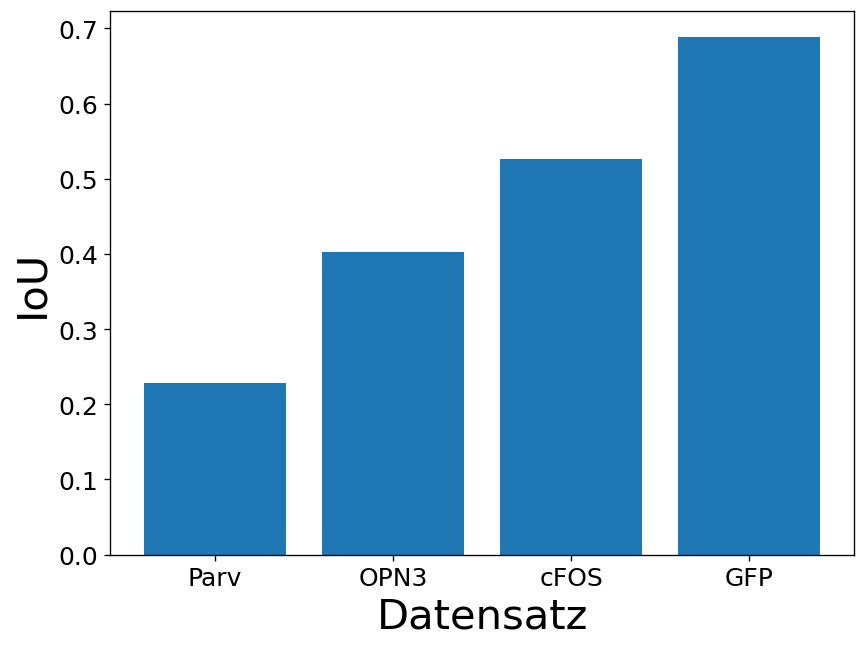

In [16]:
subds_ious = [parv_iou[0], opn_iou[0], cfos_iou[0], gfp_iou[0]]
labels = ['Parv', 'OPN3', 'cFOS', 'GFP']
fig=plt.figure(figsize=(8,6), dpi=120)
plt.bar(x=labels,height=subds_ious)
plt.ylabel('IoU').set_fontsize(25)
plt.xlabel('Datensatz').set_fontsize(25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig(os.path.join(cf.out_dir, 'plots/subds_mean_ious.png'), bbox_inches='tight')

## IoU (3 samples)

In [26]:
def batch_three(cf):

    """Assembles a batch of the first image for each specified patient.
    A tuple holding the batched image of shape (b, 1, 128, 128) and the batched
    segmentations of shape (b, 4, 128, 128).
    """
    img, seg, ids, samples, avg_masks, avg_experts = [], [], [], [], [], []
    img_ixs = glob(os.path.join(cf.out_dir, 'images', '*'))

    for i in range(len(img_ixs)):
        # get the first image for the patient
        img_path = img_ixs[i]
        pth_split = img_path.rsplit('/', 1)[-1][:-4]
        ids.append(pth_split)

        image = np.load(img_path)
        #image = image[np.newaxis, np.newaxis, ...]
        img.append(image)

        # get the corresponding ground truth label
        gt_base_path = img_path.replace('images', 'gt')
        # Für alle 4 Expertenmasken zu bestimmtem Bild:
        labels = []
        for l in range(cf.num_graders):
            gt_path = gt_base_path.replace('.npy', '_l{}.npy'.format(l))
            label = np.load(gt_path)
            labels.append(label)
        labels = np.concatenate(labels, axis=1)
        avg_expert = np.sum(labels, axis = 1)
        avg_experts.append(avg_expert)
        seg.append(labels)
        
        # Samples
        sample_base_path = img_path.replace('images/', '')
        sample_list = []
        for i in range(cf.num_graders):
            new_path = sample_base_path.replace('.npy', '_sample{}.npy'.format(i))
            sample = np.load(new_path)
            sample_list.append(sample)
        array = np.concatenate(sample_list, axis=1)
        avg_mask = np.sum(array, axis = 1)
        avg_masks.append(avg_mask)
        samples.append(array)
    
    # Concat and rearrange np arrays for BHWC format
    img_batch = np.concatenate(img, axis=0)
    img_batch = np.transpose(img_batch, (0, 2, 3, 1))
    seg_batch = np.concatenate(seg, axis=0)
    seg_batch = np.transpose(seg_batch, (0, 2, 3, 1))
    sample_batch = np.concatenate(samples, axis=0)
    sample_batch = np.transpose(sample_batch, (0, 2, 3, 1))
    avg_expert_batch = np.concatenate(avg_experts, axis=0)
    avg_mask_batch = np.concatenate(avg_masks, axis=0)
   

    batch = {'data': np.array(img_batch).astype('float32'), 'seg': np.array(seg_batch).astype('uint8'),
             'sample': np.array(sample_batch).astype('uint8'), 'avg_masks': np.array(avg_mask_batch).astype('uint8'),
             'avg_experts': np.array(avg_expert_batch).astype('uint8'), 'id': ids}

    return batch

In [27]:
batch = batch_three(cf)

In [28]:
ds_iou = mean_iou(batch['avg_masks'], batch['avg_experts']); ds_iou[0]

0.43736202023650855

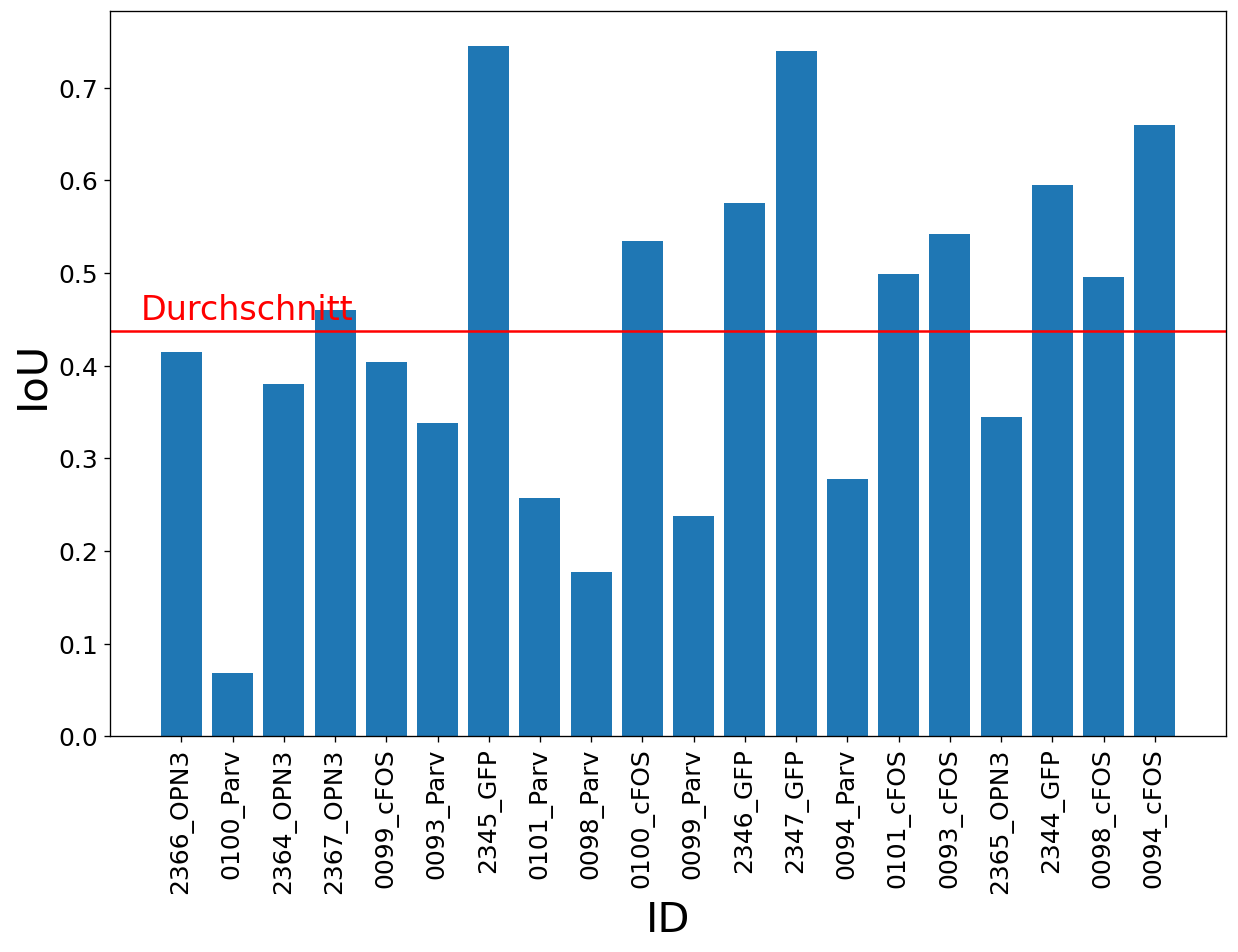

In [29]:
fig=plt.figure(figsize=(12,8), dpi=120)
plt.bar(x=batch['id'],height=ds_iou[1])
plt.ylabel('IoU').set_fontsize(25)
plt.xlabel('ID').set_fontsize(25)
plt.xticks(fontsize = 15, rotation=90)
plt.yticks(fontsize = 15)
plt.axhline(ds_iou[0], color='r')
plt.text(-0.8,0.45, 'Durchschnitt', color = 'r', fontsize=20)
plt.savefig(os.path.join(cf.out_dir, 'plots/3_samples_ds_mean_ious.png'), bbox_inches='tight')

In [21]:
parv_list = get_sublist('Parv', batch)
gfp_list = get_sublist('GFP', batch)
opn_list = get_sublist('OPN3', batch)
cfos_list = get_sublist('cFOS', batch)

In [22]:
parv_iou = mean_iou(parv_list['avg_masks'], parv_list['avg_experts']); parv_iou[0]

0.2261192544070373

In [23]:
gfp_iou = mean_iou(gfp_list['avg_masks'], gfp_list['avg_experts']); gfp_iou[0]

0.663946744123804

In [24]:
opn_iou = mean_iou(opn_list['avg_masks'], opn_list['avg_experts']); opn_iou[0]

0.39978861743757743

In [25]:
cfos_iou = mean_iou(cfos_list['avg_masks'], cfos_list['avg_experts']); cfos_iou[0]

0.522597238673737

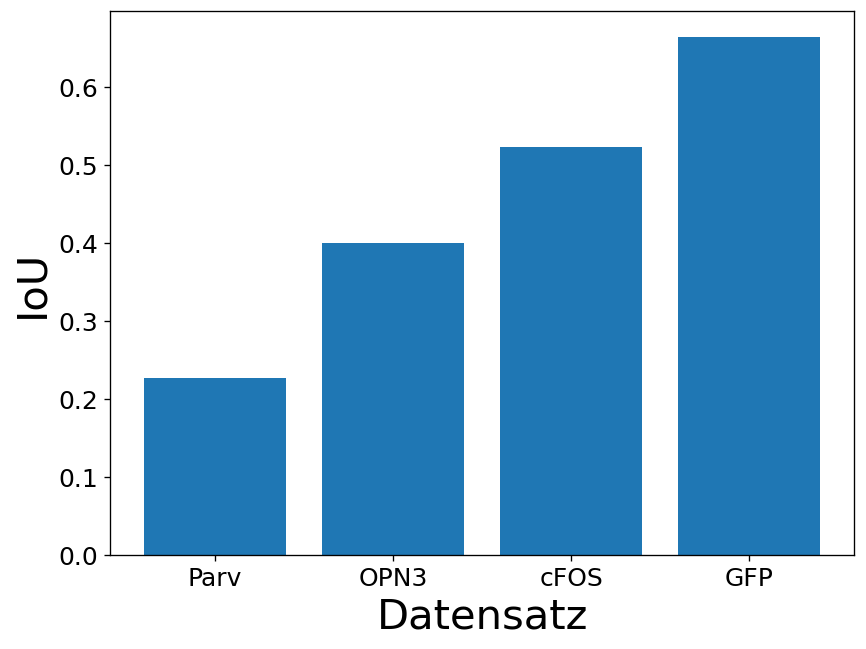

In [26]:
subds_ious = [parv_iou[0], opn_iou[0], cfos_iou[0], gfp_iou[0]]
labels = ['Parv', 'OPN3', 'cFOS', 'GFP']
fig=plt.figure(figsize=(8,6), dpi=120)
plt.bar(x=labels,height=subds_ious)
plt.ylabel('IoU').set_fontsize(25)
plt.xlabel('Datensatz').set_fontsize(25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig(os.path.join(cf.out_dir, 'plots/3_samples_subds_mean_ious.png'), bbox_inches='tight')

## Generalized Energy Distance (GED): 6 Samples

In [27]:
batch = batch_six(cf)

In [28]:
batch['seg'].shape, batch['sample'].shape[-1]

((20, 128, 128, 3), 6)

In [29]:
def ged_matrix(mask_list1, mask_list2):
    
    length1 = mask_list1.shape[-1]
    length2 = mask_list2.shape[-1]
    matrix = np.zeros(shape=(length1, length2))
    
    for i in range(length1):
        for j in range(length2):
                 single_iou = iou(mask_list1[...,i], mask_list2[...,j])
                 matrix[i,j] = 1 - single_iou
                    
    matrix_sum = np.sum(matrix)
    
    return matrix, matrix_sum

In [30]:
def calc_ged_one(expert_masks, sample_masks):
    
    d_matrix_YS, d_matrix_YS_sum = ged_matrix(expert_masks, sample_masks)
    d_matrix_SS, d_matrix_SS_sum = ged_matrix(sample_masks, sample_masks)
    d_matrix_YY, d_matrix_YY_sum = ged_matrix(expert_masks, expert_masks)
    
    d_YS = d_matrix_YS_sum/(d_matrix_YS.shape[0]*d_matrix_YS.shape[1])
    d_SS = d_matrix_SS_sum/(d_matrix_SS.shape[0]*d_matrix_SS.shape[1]-d_matrix_SS.shape[0])
    d_YY = d_matrix_YY_sum/(d_matrix_YY.shape[0]*d_matrix_YY.shape[1]-d_matrix_YY.shape[0])
    
    
    GED = 2*d_YS - d_SS - d_YY
    
    return GED, d_YS, d_SS, d_YY

In [31]:
def calc_ged_ds(expert_masks, sample_masks):
    
    GED_list, d_YS_list, d_SS_list, d_YY_list = [], [], [], []
    ds_size = expert_masks.shape[0]
    
    for i in range(ds_size):
        GED, d_YS, d_SS, d_YY = calc_ged_one(expert_masks[i], sample_masks[i])
        GED_list.append(GED)
        d_YS_list.append(d_YS)
        d_SS_list.append(d_SS)
        d_YY_list.append(d_YY)
    
    ds_GED = sum(GED_list)/ds_size
    ds_d_YS = sum(d_YS_list)/ds_size
    ds_d_SS = sum(d_SS_list)/ds_size
    ds_d_YY = sum(d_YY_list)/ds_size
    
    return ds_GED, ds_d_YS, ds_d_SS,  ds_d_YY

In [32]:
ds_ged, ds_d_ys, ds_d_ss, ds_d_yy = calc_ged_ds(batch['seg'], batch['sample'])

In [33]:
ds_ged, ds_d_ys, ds_d_ss, ds_d_yy

(0.34433312111912234,
 0.5211557993876137,
 0.2163910410468989,
 0.4815874366092059)

## Generalized Energy Distance (GED): 3 Samples

In [34]:
batch = batch_three(cf)

In [35]:
ds3_ged, ds3_d_ys, ds3_d_ss, ds3_d_yy = calc_ged_ds(batch['seg'], batch['sample'])

In [36]:
ds3_ged, ds3_d_ys, ds3_d_ss, ds3_d_yy

(0.3213259924130681,
 0.5202213611187966,
 0.23752929321531918,
 0.4815874366092059)

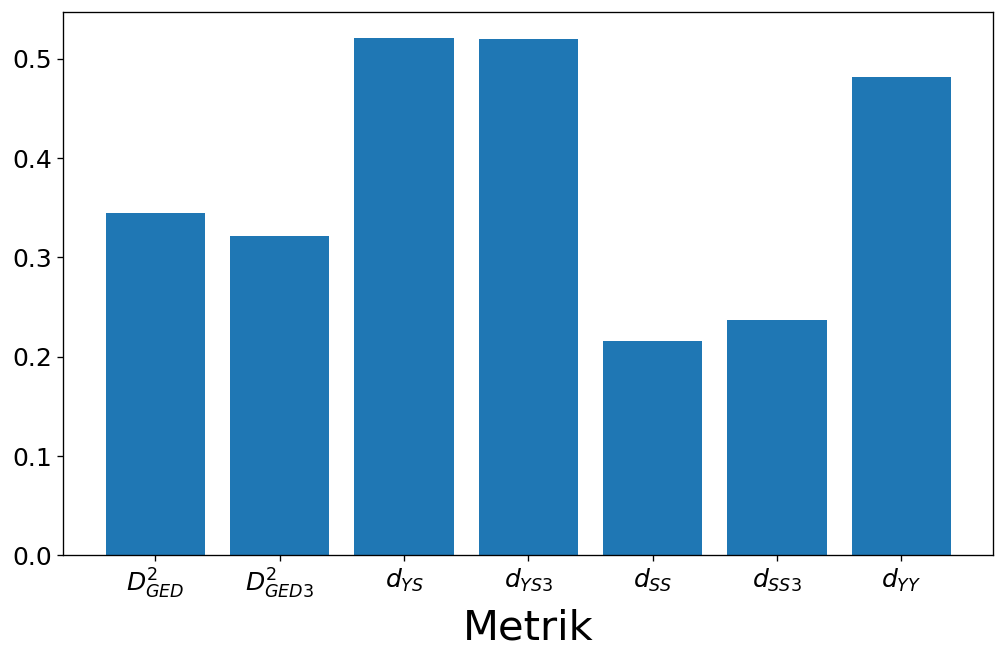

In [37]:
data = [ds_ged, ds3_ged, ds_d_ys, ds3_d_ys, ds_d_ss, ds3_d_ss, ds_d_yy]
labels = ['$D^2_{GED}$', '$D^2_{GED3}$', '$d_{YS}$', '$d_{YS3}$', '$d_{SS}$', '$d_{SS3}$', '$d_{YY}$']
fig=plt.figure(figsize=(10,6), dpi=120)
plt.bar(x=labels,height=data)
plt.xlabel('Metrik').set_fontsize(25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig(os.path.join(cf.out_dir, 'plots/distance_metrics.png'), bbox_inches='tight')